In [1]:
pip install seaborn matplotlib fastparquet astroquery pyspark plotly nbformat>=4.2.0 

zsh:1: 4.2.0 not found
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from astroquery.gaia import Gaia
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, log10, lit, when
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# --- PART 1: GET THE DATA (Astroquery) ---
# We fetch data only if we haven't already saved it to avoid spamming ESA servers.
parquet_path = "../data/gaia_main.parquet"

if not os.path.exists(parquet_path):
    print(">> Local cache not found. Querying ESA Gaia Archive (TAP)...")
    
    # ADQL Query: Volume-limited to 100 parsecs (parallax >= 10)
    # This guarantees we catch the dim White Dwarfs.
    adql_query = """
    SELECT TOP 1000000
        source_id, ra, dec, parallax, parallax_error, 
        pmra, pmdec, phot_g_mean_mag, bp_rp, teff_gspphot
    FROM gaiadr3.gaia_source
    WHERE parallax >= 0 
      AND parallax_over_error > 5
      AND phot_g_mean_mag IS NOT NULL
      AND bp_rp IS NOT NULL
      AND teff_gspphot IS NOT NULL
    """
    
    # Launch async job (safest for laptops on wifi)
    job = Gaia.launch_job_async(adql_query)
    res = job.get_results()
    
    # Convert to Pandas -> Parquet (Intermediate storage)
    print(f">> Downloaded {len(res)} stars. Saving to Parquet...")
    pdf = res.to_pandas()
    
    # Clean up column types for Parquet (sometimes Astropy uses object types)
    for c in pdf.columns:
        if pdf[c].dtype == 'object':
            pdf[c] = pdf[c].astype(str)
            
    pdf.to_parquet(parquet_path)
else:
    print(">> Found cached data. Skipping download.")


>> Found cached data. Skipping download.


In [13]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sin, cos, acos, asin, radians, degrees, sqrt, abs, pow, lit

# 1. Initialize Spark session
spark = SparkSession.builder.appName("Galactic_Plane_Halo_Query").getOrCreate()

# 2. Load data
# Make sure 'parquet_path' is defined, e.g., parquet_path = "../data/clean"
parquet_path = "../data/clean" 
raw_df = spark.read.parquet(parquet_path)

# --- THE FIX: CALCULATE GALACTIC LATITUDE (b) AS POSITIVE ---
# We use the North Galactic Pole (NGP) coordinates to convert RA/Dec to b
ra_ngp = 192.85948
dec_ngp = 27.12825

clean_df = raw_df.withColumn(
    "b_radians",
    asin(
        sin(radians(col("dec"))) * sin(radians(lit(dec_ngp))) +
        cos(radians(col("dec"))) * cos(radians(lit(dec_ngp))) * cos(radians(col("ra") - lit(ra_ngp)))
    )
).withColumn(
    "b", 
    # CHANGE IS HERE: We wrap degrees() in abs() to force positive values
    abs(degrees(col("b_radians"))) 
)

# 3. Register as temporary view
clean_df.createOrReplaceTempView("clean_df")

print("Data loaded. Calculated POSITIVE column 'b' (Absolute Galactic Latitude).")
# clean_df.select("source_id", "ra", "dec", "b").show(5)

Data loaded. Calculated POSITIVE column 'b' (Absolute Galactic Latitude).


In [4]:
clean_df.show(10)

+--------------+------------------+-------------------+------------------+--------------+-------------------+-------------------+---------------+----------+------------+-------------------+-------------------+
|     source_id|                ra|                dec|          parallax|parallax_error|               pmra|              pmdec|phot_g_mean_mag|     bp_rp|teff_gspphot|          b_radians|                  b|
+--------------+------------------+-------------------+------------------+--------------+-------------------+-------------------+---------------+----------+------------+-------------------+-------------------+
| 7387343906304| 45.07076738605656|0.23473370815260622| 2.641564994337502|    0.04222455| 3.4028150649290785| -18.20028169017168|       15.05918| 1.5323629|   4458.5513|-0.8497781522076241| -48.68870164392254|
|13164075594240| 45.26333628178132|0.36935645995028626|0.8101966346135607|   0.059051972|  5.944063156854327| -3.725158772786984|       16.10833| 1.0780106|   5


## The SQL Query (Galactic Plane & Halo Motion)(This replaces the second code cell. This is where we implement the physics logic: $Distance = \sqrt{pmra^2 + pmdec^2}$ and Filters).


In [14]:
# Define the query to classify regions and calculate speed
halo_query = """
SELECT
    source_id,
    b AS galactic_latitude,
    
    -- Calculate Total Proper Motion Magnitude (The Speed)
    SQRT(POWER(pmra, 2) + POWER(pmdec, 2)) AS total_motion,
    
    -- Classify based on position (b) and Motion
    CASE 
        WHEN b < 10 THEN 'Galactic Plane (Disk)'
        -- Note: High Velocity threshold set to > 50 mas/yr
        WHEN b > 30 AND SQRT(POWER(pmra, 2) + POWER(pmdec, 2)) > 50 THEN 'Halo Candidate (High Velocity)'
        ELSE 'Background / Thick Disk'
    END AS galaxy_component

FROM clean_df
WHERE
    -- Filter out nulls
    b IS NOT NULL 
    AND pmra IS NOT NULL 
    AND pmdec IS NOT NULL
    -- Optimization: Filter out static stars
    AND SQRT(POWER(pmra, 2) + POWER(pmdec, 2)) > 0
"""

# Run the query
halo_df = spark.sql(halo_query)

# Show a preview
halo_df.show(5)

# Persist for visualization
output_dir = "../data/halo_analysis"
halo_df.coalesce(1).write.mode("overwrite").parquet(output_dir)
print(f"Halo analysis data written to {output_dir}")

+--------------------+------------------+------------------+--------------------+
|           source_id| galactic_latitude|      total_motion|    galaxy_component|
+--------------------+------------------+------------------+--------------------+
|1.624902306986160...|19.651284375334154|1.0167359639790903|Background / Thic...|
|1.624902607596348...| 19.64194428434692| 5.131872184665036|Background / Thic...|
|1.624902650582014...|19.637278374028398|1.7406013855803115|Background / Thic...|
|1.624902650582045...|19.649804914760498|2.9641836245333293|Background / Thic...|
|1.624902951193701...|19.659613657296347|0.7090033086969081|Background / Thic...|
+--------------------+------------------+------------------+--------------------+
only showing top 5 rows


[Stage 13:>                                                         (0 + 1) / 1]

Halo analysis data written to ../data/halo_analysis


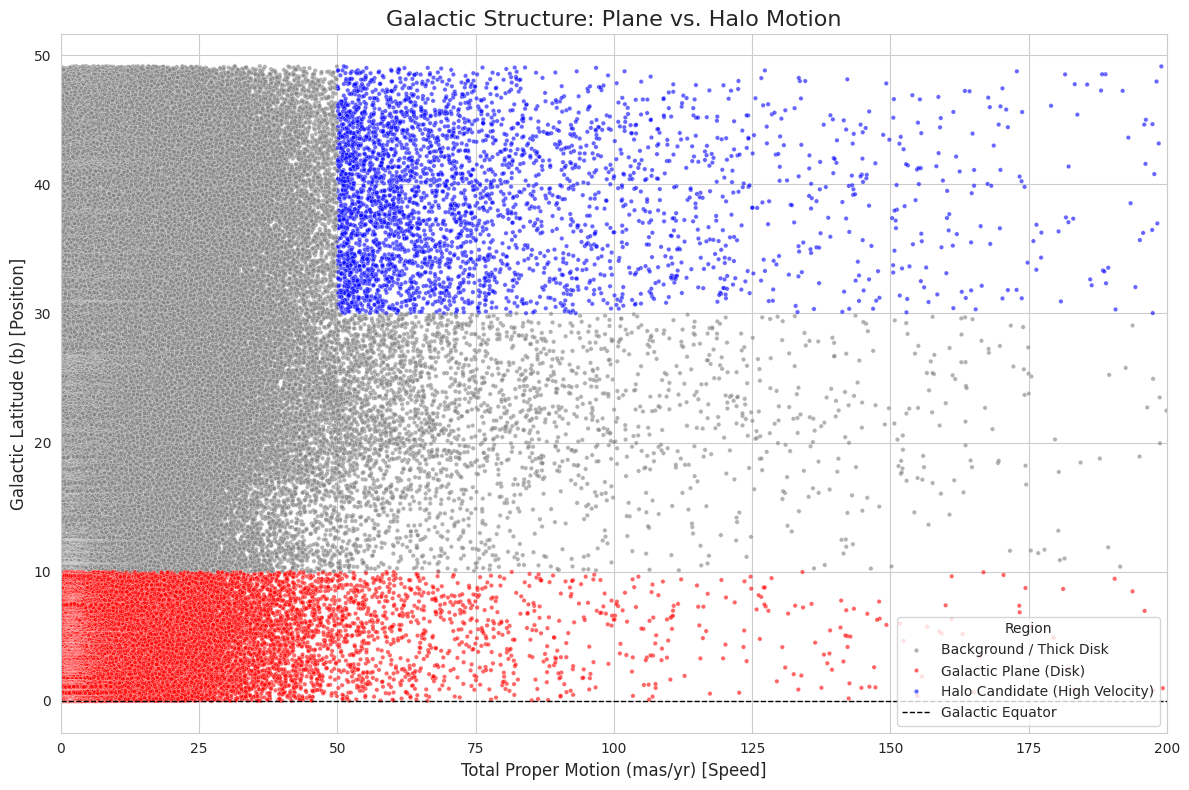

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load the processed data into Pandas for plotting
# Sample fraction=0.1 to avoid crashing the plotter if data is huge
plot_data = halo_df.sample(fraction=0.1, seed=42).toPandas()

plt.figure(figsize=(12, 8))

# Scatter plot
sns.scatterplot(
    data=plot_data,
    x="total_motion",
    y="galactic_latitude",
    hue="galaxy_component",
    alpha=0.6,
    palette={"Galactic Plane (Disk)": "red", "Halo Candidate (High Velocity)": "blue", "Background / Thick Disk": "grey"},
    s=10
)

plt.title("Galactic Structure: Plane vs. Halo Motion", fontsize=16)
plt.xlabel("Total Proper Motion (mas/yr) [Speed]", fontsize=12)
plt.ylabel("Galactic Latitude (b) [Position]", fontsize=12)
plt.axhline(0, color='black', linestyle='--', linewidth=1, label="Galactic Equator")
plt.legend(title="Region")
plt.xlim(0, 200) # Limit x-axis to zoom in on the main cluster

plt.tight_layout()
plt.show()

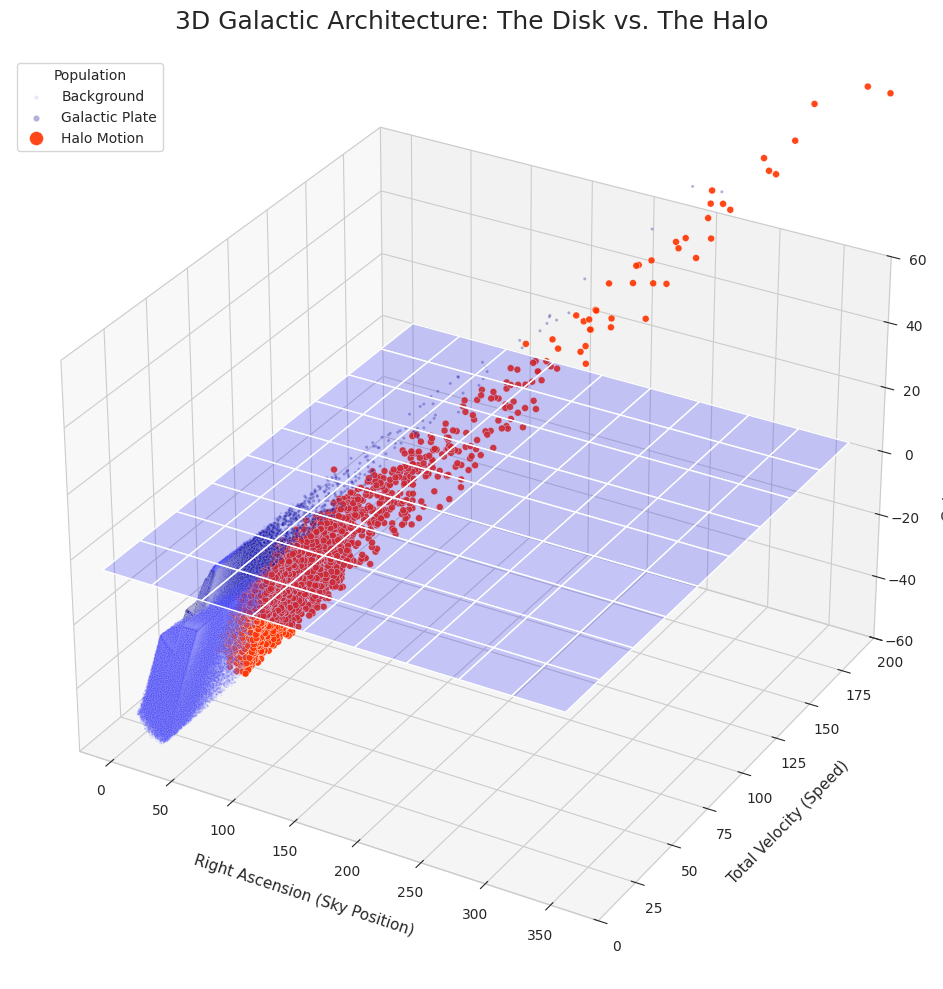

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np

# 1. Prepare Data (Same "All-in-One" SQL logic)
plot_df = spark.sql("""
SELECT 
    ra, 
    -- Calculate Galactic Latitude (b)
    DEGREES(ASIN(
        SIN(RADIANS(dec)) * SIN(RADIANS(27.12825)) +
        COS(RADIANS(dec)) * COS(RADIANS(27.12825)) * COS(RADIANS(ra - 192.85948))
    )) AS b,
    -- Calculate Speed
    SQRT(POWER(pmra, 2) + POWER(pmdec, 2)) AS total_motion,
    
    CASE 
        WHEN ABS(DEGREES(ASIN(
            SIN(RADIANS(dec)) * SIN(RADIANS(27.12825)) +
            COS(RADIANS(dec)) * COS(RADIANS(27.12825)) * COS(RADIANS(ra - 192.85948))
        ))) < 10 THEN 'Galactic Plate'
        WHEN SQRT(POWER(pmra, 2) + POWER(pmdec, 2)) > 50 THEN 'Halo Motion'
        ELSE 'Background'
    END AS component
FROM clean_df
WHERE pmra IS NOT NULL AND pmdec IS NOT NULL
""").sample(fraction=0.05, seed=42).toPandas()

# 2. Setup "Clean Science" Theme
sns.set_style("whitegrid")
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

# 3. Define Colors (High Contrast)
# Disk = Deep Navy Blue (Stable)
# Halo = Bright Red (High Energy/Speed)
colors = {'Galactic Plate': '#000080', 'Halo Motion': '#ff3300', 'Background': 'blue'}
alphas = {'Galactic Plate': 0.3, 'Halo Motion': 0.9, 'Background': 0.1}
sizes =  {'Galactic Plate': 5,   'Halo Motion': 25,  'Background': 2}

# 4. Plot each group
# We Iterate to plot them as separate layers
for comp in ['Background', 'Galactic Plate', 'Halo Motion']: # Order matters for layering
    group = plot_df[plot_df['component'] == comp]
    ax.scatter(
        group['ra'],           # X: Position across sky
        group['total_motion'], # Y: Velocity (Now Horizontal/Depth)
        group['b'],            # Z: Latitude (The Vertical Position)
        c=colors[comp],
        label=comp,
        s=sizes[comp],
        alpha=alphas[comp],
        edgecolor='white',     # Add small white border for clarity
        linewidth=0.3
    )

# 5. Add the "Galactic Layer" (The physical Plane representation)
# This draws a transparent blue sheet at Z=0 to show exactly where the plane is
xx, yy = np.meshgrid(np.linspace(0, 360, 10), np.linspace(0, 200, 10))
zz = np.zeros_like(xx) # The Flat Plane at b=0
ax.plot_surface(xx, yy, zz, alpha=0.2, color='blue', shade=False)

# 6. Intuitive Labels
ax.set_title("3D Galactic Architecture: The Disk vs. The Halo", fontsize=18, pad=20)
ax.set_xlabel("Right Ascension (Sky Position)", fontsize=11, labelpad=10)
ax.set_ylabel("Total Velocity (Speed)", fontsize=11, labelpad=10) # Horizontal now
ax.set_zlabel("Galactic Latitude (b)", fontsize=11, labelpad=10)  # Vertical now

# 7. Set Limits to focus the view
ax.set_zlim(-60, 60) # Zoom in on the thickness of the disk
ax.set_ylim(0, 200)  # Focus on the velocity transition

# View Angle: Slightly above, looking "down" at the plate
ax.view_init(elev=30, azim=-60)

plt.legend(markerscale=2, title="Population")
plt.tight_layout()
plt.show()

In [18]:
import plotly.graph_objects as go
import numpy as np

# OPTIONAL PERFORMANCE TIP:
# Since you are zooming in to RA 0-50, filtering the dataframe first 
# will make the interaction much smoother than just hiding the other points.
# plot_df = plot_df[(plot_df['ra'] >= 0) & (plot_df['ra'] <= 50)]

# --- 1. Setup Styling Dictionaries ---
colors = {'Galactic Plate': '#000080', 'Halo Motion': '#ff3300', 'Background': 'blue'}
opacities = {'Galactic Plate': 0.4, 'Halo Motion': 0.9, 'Background': 0.15}
sizes =     {'Galactic Plate': 3,   'Halo Motion': 6,    'Background': 2}

# --- 2. Initialize the Figure ---
fig = go.Figure()

# --- 3. Plot the Groups ---
for comp in ['Background', 'Galactic Plate', 'Halo Motion']:
    group = plot_df[plot_df['component'] == comp]
    
    fig.add_trace(go.Scatter3d(
        x=group['ra'],
        y=group['total_motion'],
        z=group['b'],
        mode='markers',
        name=comp,
        marker=dict(
            size=sizes[comp],
            color=colors[comp],
            opacity=opacities[comp],
            line=dict(width=0)
        ),
        hovertemplate=(
            f"<b>{comp}</b><br>" +
            "RA: %{x:.2f}<br>" +
            "Speed: %{y:.2f} km/s<br>" +
            "Lat (b): %{z:.2f}<extra></extra>"
        )
    ))

# --- 4. Add the "Galactic Layer" (The Zero Plane) ---
# We adjust the plane mesh to match your new RA view (0 to 50) 
# so the blue sheet doesn't stretch out into empty space.
x_plane = np.linspace(0, 50, 2) # <--- Adjusted to match new view
y_plane = np.linspace(0, 200, 2)
x_grid, y_grid = np.meshgrid(x_plane, y_plane)
z_grid = np.zeros_like(x_grid)

fig.add_trace(go.Surface(
    x=x_grid,
    y=y_grid,
    z=z_grid,
    colorscale=[[0, 'blue'], [1, 'blue']],
    opacity=0.2,
    showscale=False,
    name='Galactic Plane Reference',
    hoverinfo='skip'
))

# --- 5. Layout ---
fig.update_layout(
    title=dict(
        text="<b>3D Galactic Architecture</b><br>Focus: RA 0-50 deg",
        y=0.9,
        x=0.5,
        xanchor='center',
        yanchor='top',
        font=dict(size=20)
    ),
    scene=dict(
        xaxis_title='Right Ascension (deg)',
        yaxis_title='Total Velocity (Speed)',
        zaxis_title='Galactic Latitude (b)',
        
        # --- CHANGED HERE ---
        xaxis=dict(range=[0, 100]), # Focus on the specific RA slice
        # --------------------
        
        yaxis=dict(range=[0, 200]),
        zaxis=dict(range=[-60, 60]),
        
        xaxis_backgroundcolor="white",
        yaxis_backgroundcolor="white",
        zaxis_backgroundcolor="white",
        
        aspectmode='manual',
        aspectratio=dict(x=1, y=1, z=0.6)
    ),
    margin=dict(r=0, l=0, b=0, t=50),
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
        bgcolor="rgba(255, 255, 255, 0.8)"
    )
)

# --- 6. Show ---
# Remember: If using Databricks, use displayHTML(fig.to_html(...)) instead
fig.show()